In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from scipy.linalg import inv
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Load Data

In [2]:
columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']
vertebral_df = pd.read_csv('data/vertebral_column_data/column_2C.dat', sep=' ', header=None, names=columns)
vertebral_df['class'] = vertebral_df['class'].map({'NO': 0, 'AB': 1})
vertebral_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,0
306,53.94,20.72,29.22,33.22,114.37,-0.42,0
307,61.45,22.69,46.17,38.75,125.67,-2.71,0
308,45.25,8.69,41.58,36.56,118.55,0.21,0


# Pre-Processing and Exploratory Data Analysis

# *Scatterplots* 

C:\Users\thoma\miniconda3\envs\pydata-book\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


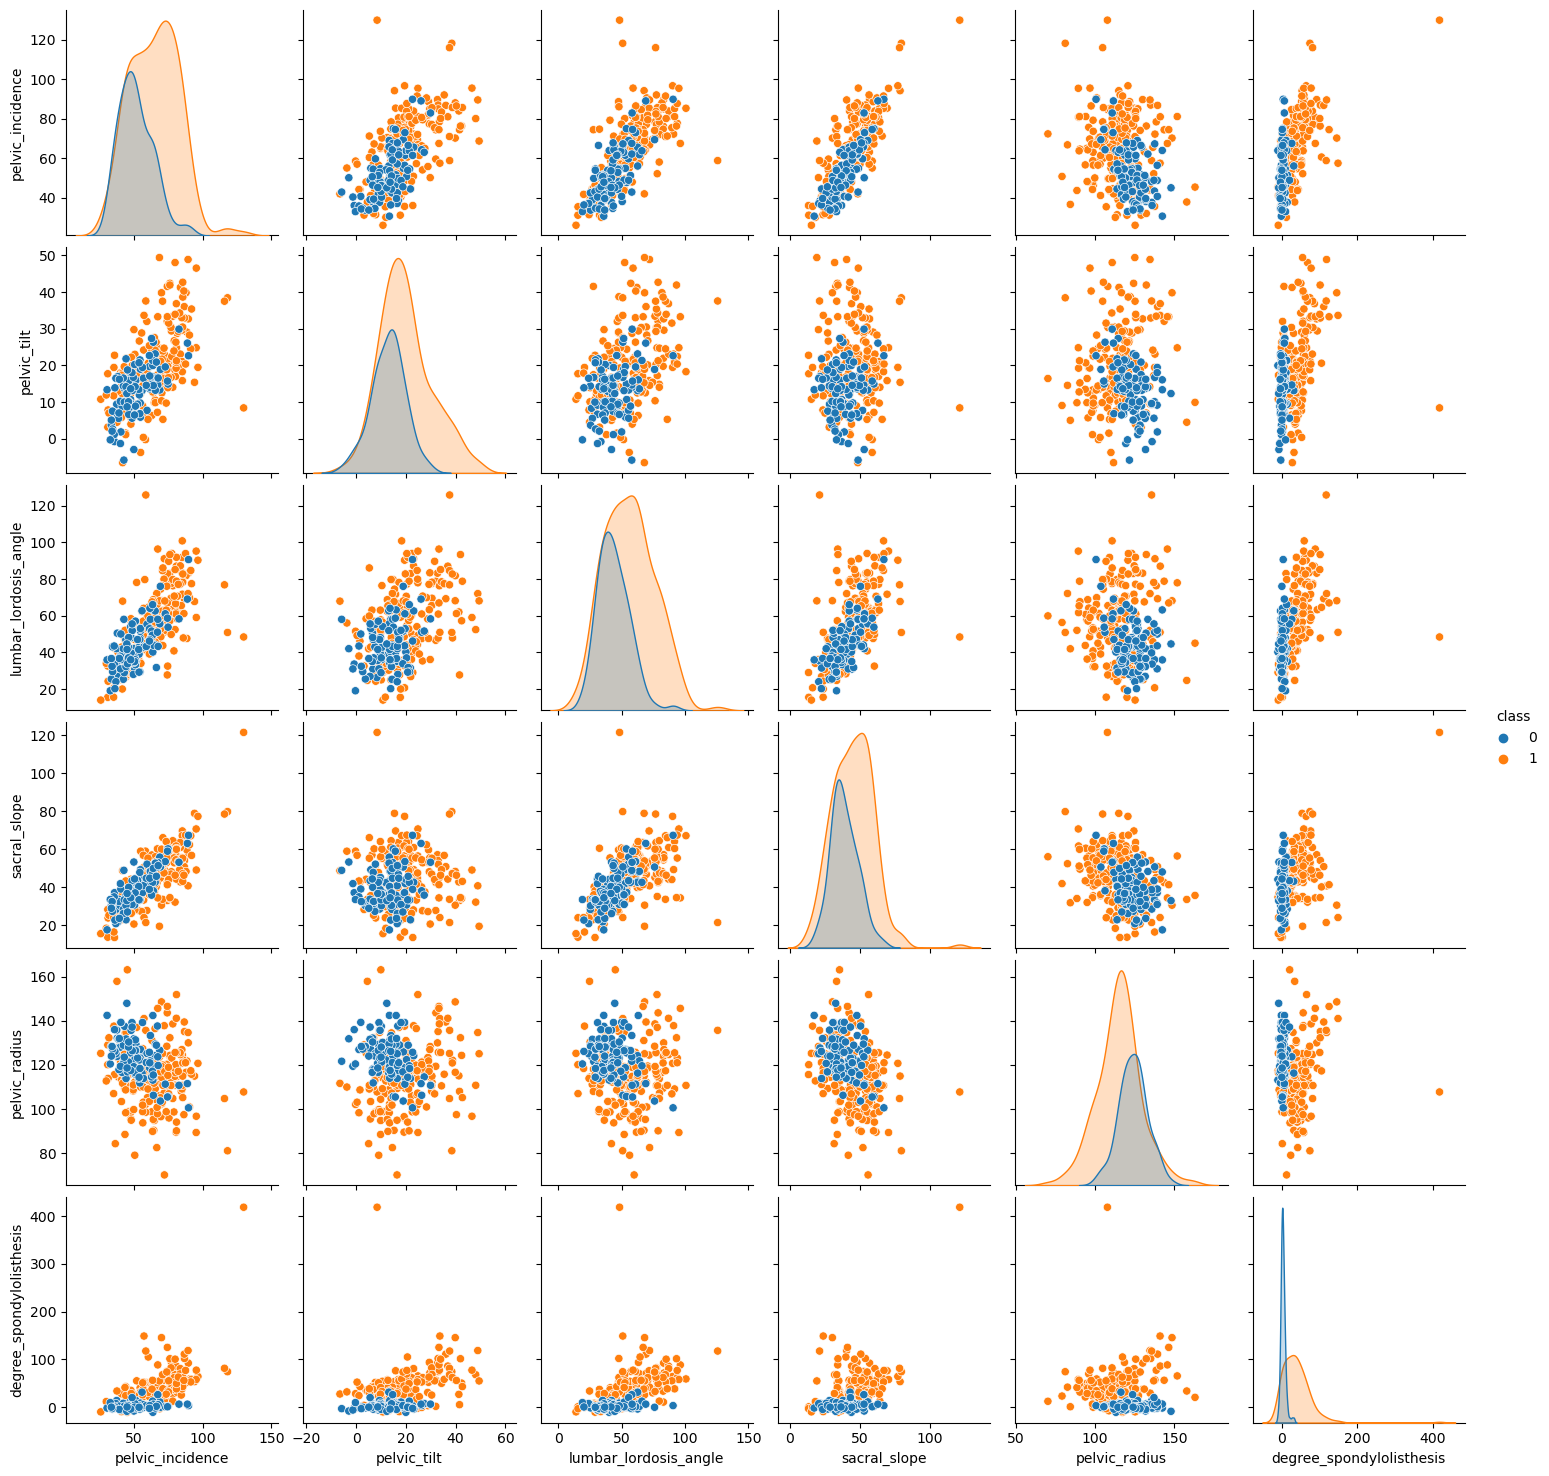

In [3]:
sns.pairplot(vertebral_df, hue="class", diag_kind="kde")
plt.show()

# *Boxplots* #

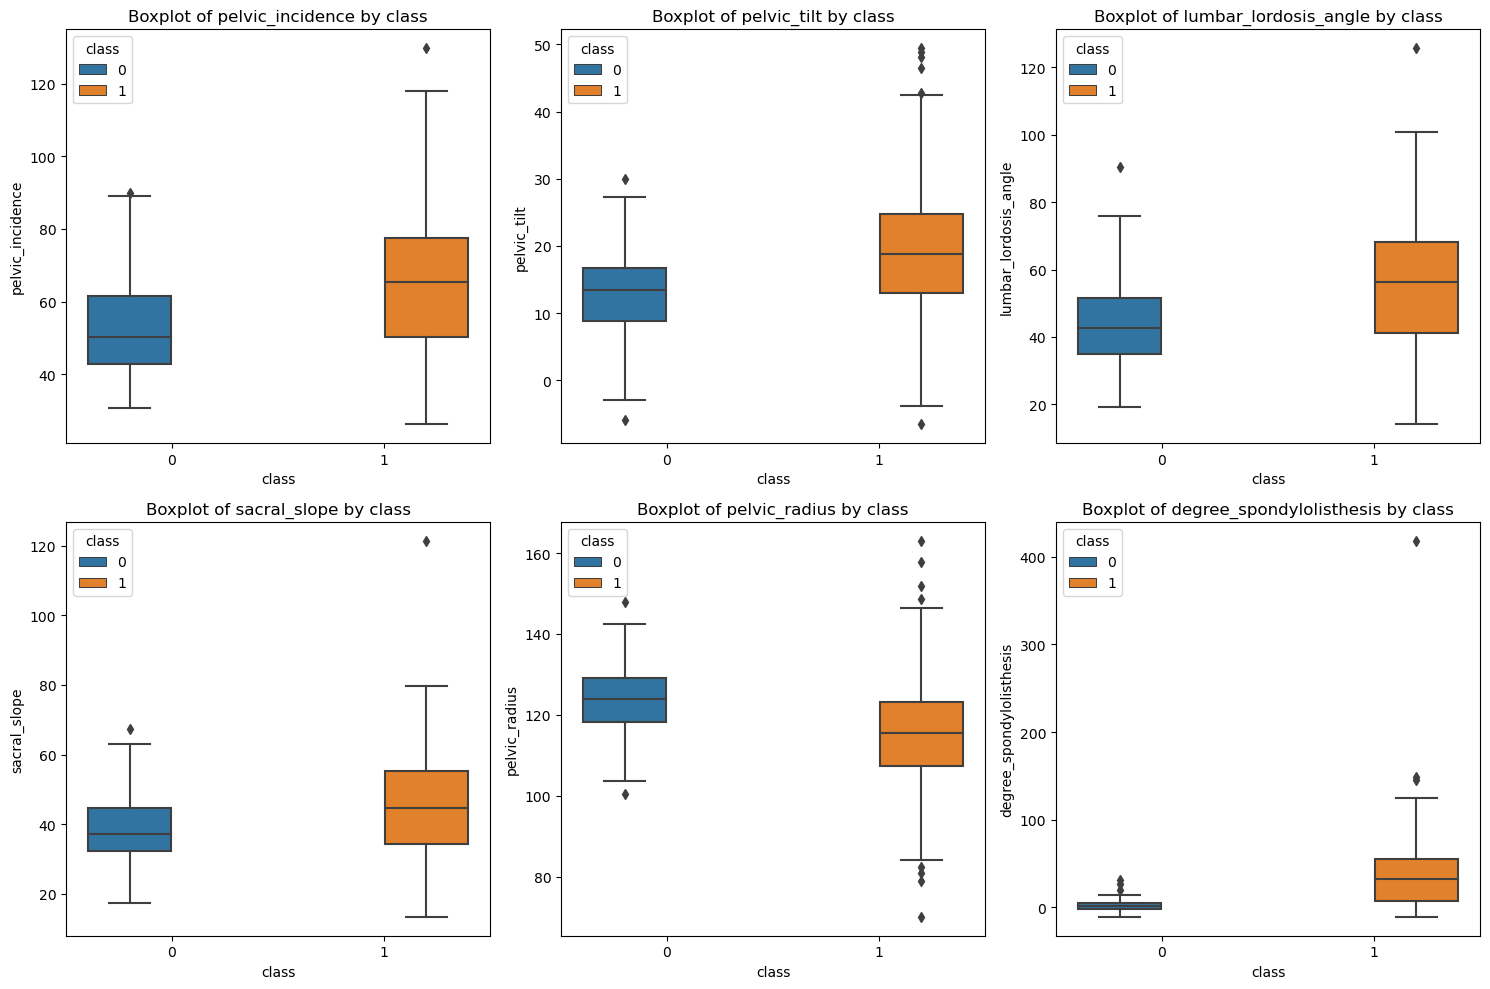

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
iv = list(vertebral_df.columns)[:-1]
axes = axes.flatten()

for i, var in enumerate(iv):
    sns.boxplot(x='class', y=var, data=vertebral_df, ax=axes[i], hue='class')
    axes[i].set_title(f'Boxplot of {var} by class')
    
plt.tight_layout()
plt.show()

# Split Data Set

In [5]:
class_0 = vertebral_df[vertebral_df['class'] == 0]
class_1 = vertebral_df[vertebral_df['class'] == 1]

class_0_train = class_0.iloc[:70,:]
class_1_train = class_1.iloc[:140, :]
train_data = pd.concat([class_1_train, class_0_train])
train_data = train_data.reset_index(drop=True)

class_0_test = class_0.iloc[70:,:]
class_1_test = class_1.iloc[140:, :]
test_data = pd.concat([class_1_test, class_0_test])
test_data = test_data.reset_index(drop=True)

print(f"Training Data Dimensions: {train_data.shape}")
print(f"Test Data Dimensions: {test_data.shape}")

Training Data Dimensions: (210, 7)
Test Data Dimensions: (100, 7)


# Classification

# *Euclidean Metric*

In [6]:
def knn_evaluation(k, train, test):

    X_train = train.iloc[:, :-1] 
    X_test = test.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    y_test = test.iloc[:, -1]
    
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)

    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    
    return train_error, test_error

# *Test Data*

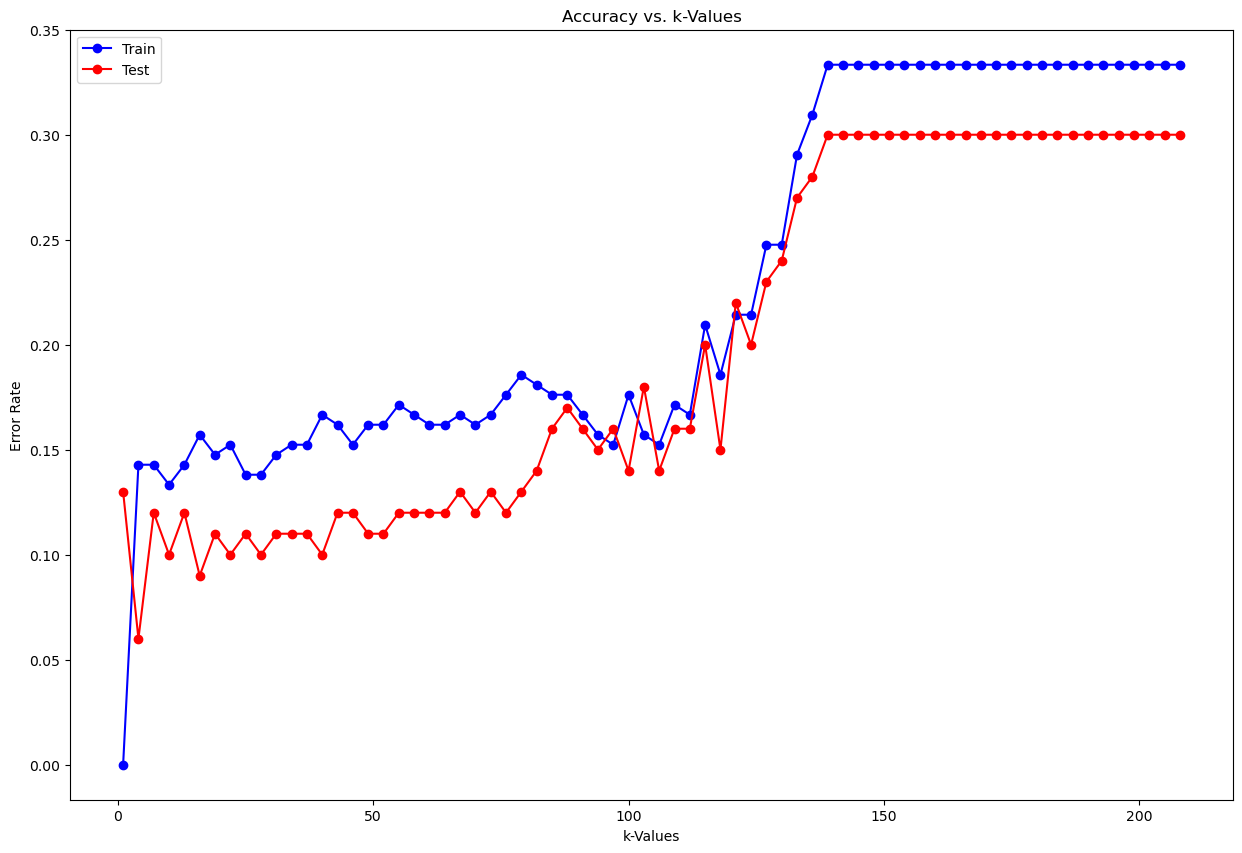

In [7]:
scores_dict = {}

for k in range(208, 0, -3):
    train_error, test_error = knn_evaluation(k, train_data, test_data)
    scores_dict[k] = [train_error, test_error]

k_values = list(scores_dict.keys())
error_scores = list(scores_dict.values())
train_scores = list(error_scores[i][0] for i in range(len(error_scores)))
test_scores = list(error_scores[i][1] for i in range(len(error_scores)))

# Plot the data
plt.figure(figsize=(15, 10))
plt.plot(k_values, train_scores, marker='o', linestyle='-', color='b', label='Train')
plt.plot(k_values, test_scores, marker='o', linestyle='-', color='r', label='Test')

# Add titles and labels
plt.title('Accuracy vs. k-Values')
plt.xlabel('k-Values')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

In [8]:
best_index = test_scores.index(min(test_scores))
best_k = k_values[best_index]
print(best_k)

4


Precision: 0.93
Recall: 0.99
F1-Score: 0.96


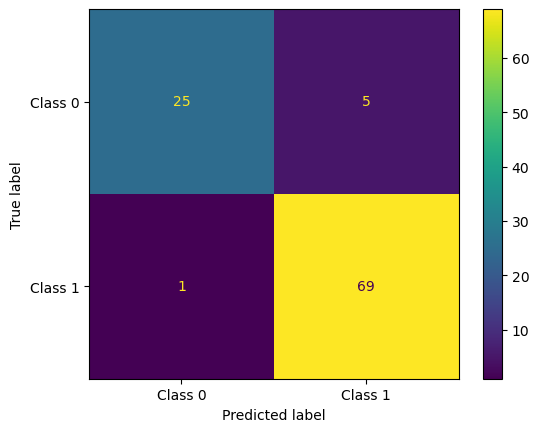

In [9]:
X_train = train_data.iloc[:, :-1] 
X_test = test_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
display.plot()
plt.show()

# *Learning Curve*

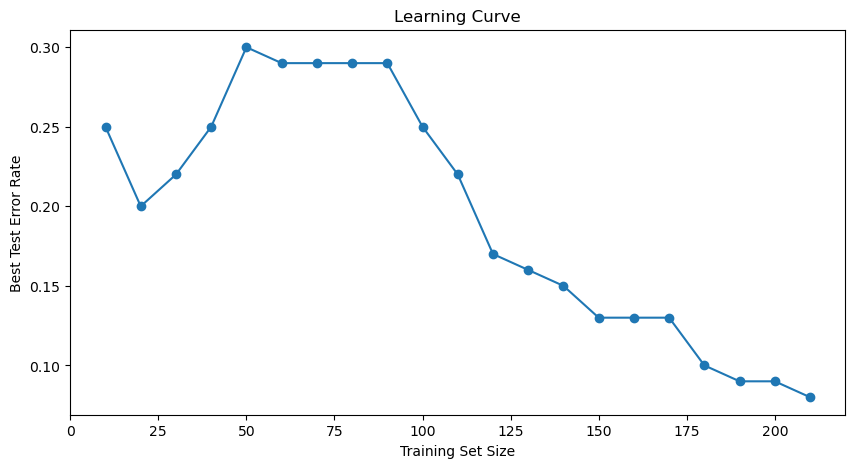

In [10]:
training_sizes = list(range(10, 211, 10))
best_test_errors = []

for N in training_sizes:
    class_0_size = int(N/3)
    class_1_size = N - class_0_size

    class_0_train_subset = class_0.iloc[:class_0_size,:]
    class_1_train_subset = class_1.iloc[:class_1_size, :]
    train_subset = pd.concat([class_0_train_subset, class_1_train_subset])

    X_train_subset = train_subset.iloc[:, :-1]
    y_train_subset = train_subset.iloc[:, -1]

    k_range = list(range(1, N, 5))
    best_test_error = 1

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train_subset, y_train_subset)
        y_pred = knn.predict(X_test)
        error = 1 - accuracy_score(y_test, y_pred)

        if error < best_test_error:
            best_test_error = error

    best_test_errors.append(best_test_error)

plt.figure(figsize=(10, 5))
plt.plot(training_sizes, best_test_errors, marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Best Test Error Rate')
plt.show()

# Other Metrics

# *Minkowski Distance*

##### A. Manhattan Distance with p = 1.

In [11]:
def best_k(metric, p_value, X_train, y_train, X_test, y_test):
    
    k_range = list(range(1, 197, 5))
    test_errors = []
    train_errors = []
    
    for k in k_range:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=p_value)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        test_error = 1 - accuracy_score(y_test, y_test_pred)
        train_error  = 1 - accuracy_score(y_train, y_train_pred)
        test_errors.append(test_error)
        train_errors.append(train_error)
    
    # Plot the data
    plt.figure(figsize=(15, 10))
    plt.plot(k_range, train_errors, marker='o', linestyle='-', color='b', label='Train')
    plt.plot(k_range, test_errors, marker='o', linestyle='-', color='r', label='Test')
    
    # Add titles and labels
    plt.title('Error Rate vs. k-Values')
    plt.xlabel('k-Values')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.show()

    best_test_error = min(test_errors)
    best_index = test_errors.index(min(test_errors))
    best_k = k_range[best_index]
    train_error = train_errors[best_index]

    return best_k, best_test_error, train_error

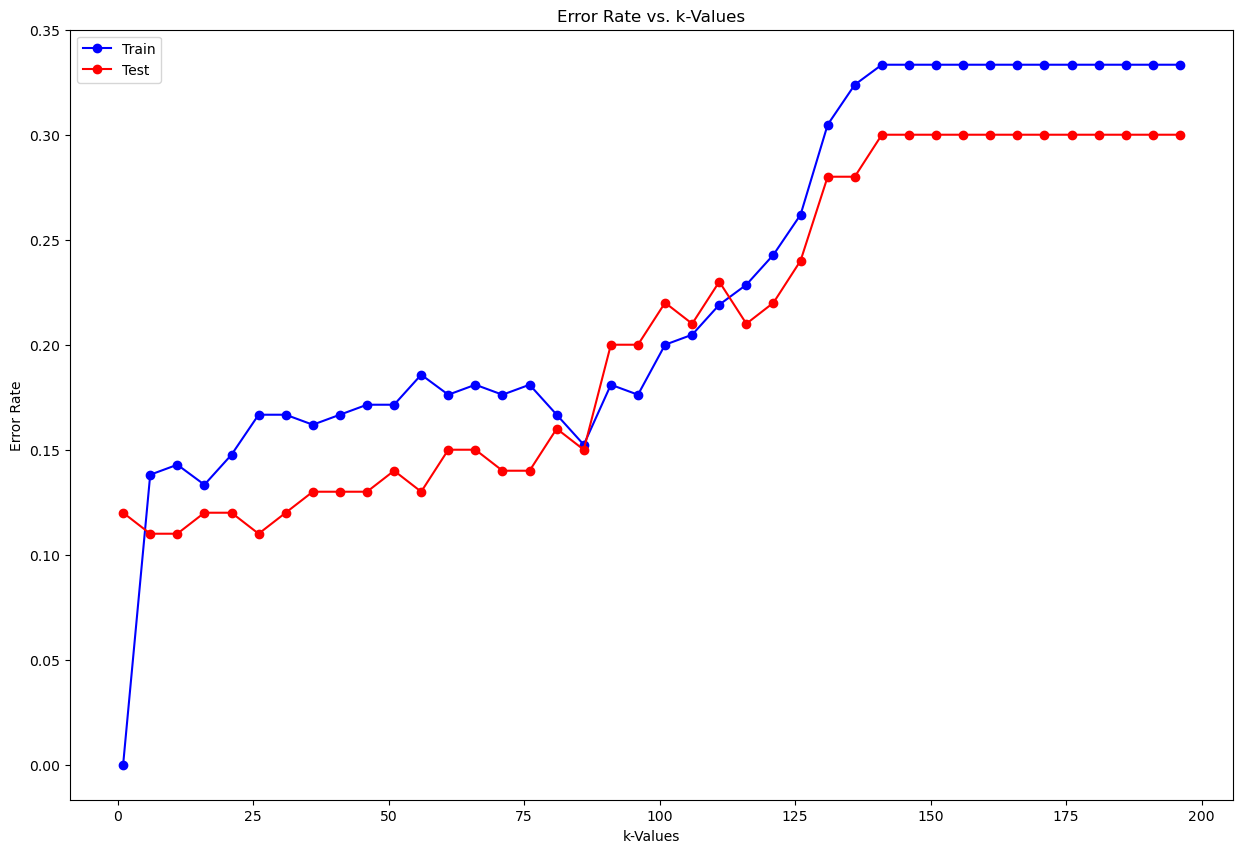

k* = 6
Best Manhattan Distance Test Error: 0.11
Manhattan Distance Train Error: 0.14


In [12]:
best_k_manhattan, best_error_manhattan, train_error_manhattan = best_k('minkowski', 1, X_train, y_train, X_test, y_test)
print('k* =', best_k_manhattan)
print(f'Best Manhattan Distance Test Error: {best_error_manhattan:.2f}')
print(f'Manhattan Distance Train Error: {train_error_manhattan:.2f}')

##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

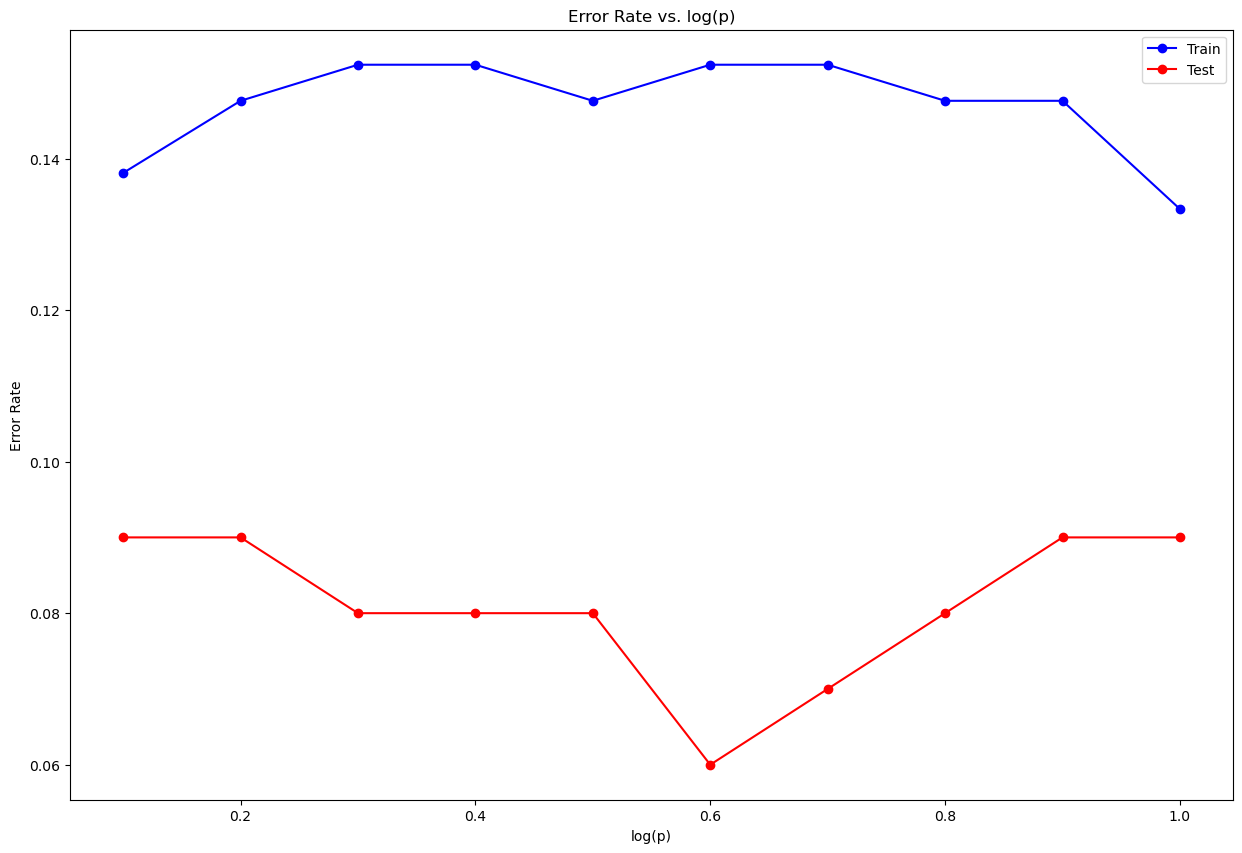

In [13]:
log_range = np.arange(0.1, 1.1, 0.1)
index = 0
test_errors = []
train_errors = []

for i in log_range:
    index += 1
    p_value = 10 ** i
    
    knn_minkowski = KNeighborsClassifier(n_neighbors=best_k_manhattan, metric='minkowski', p=p_value)
    knn_minkowski.fit(X_train, y_train)
    y_test_pred = knn_minkowski.predict(X_test)
    y_train_pred = knn_minkowski.predict(X_train)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    train_error  = 1 - accuracy_score(y_train, y_train_pred)
    test_errors.append(test_error)
    train_errors.append(train_error)

# Plot the data
plt.figure(figsize=(15, 10))
plt.plot(log_range, train_errors, marker='o', linestyle='-', color='b', label='Train')
plt.plot(log_range, test_errors, marker='o', linestyle='-', color='r', label='Test')

# Add titles and labels
plt.title('Error Rate vs. log(p)')
plt.xlabel('log(p)')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

In [14]:
best_error_minkowski = min(test_errors)
best_index = test_errors.index(min(test_errors))
best_log_p = log_range[best_index]
train_error_minkowski = train_errors[best_index]
print('log(p)* =', best_log_p)
print(f'Best Minkowski Distance Test Error: {best_error_minkowski:.2f}')
print(f'Minkowski Distance Train Error: {train_error_minkowski:.2f}')

log(p)* = 0.6
Best Minkowski Distance Test Error: 0.06
Minkowski Distance Train Error: 0.15


##### C. Chebyshev Distance With p -> infinity.

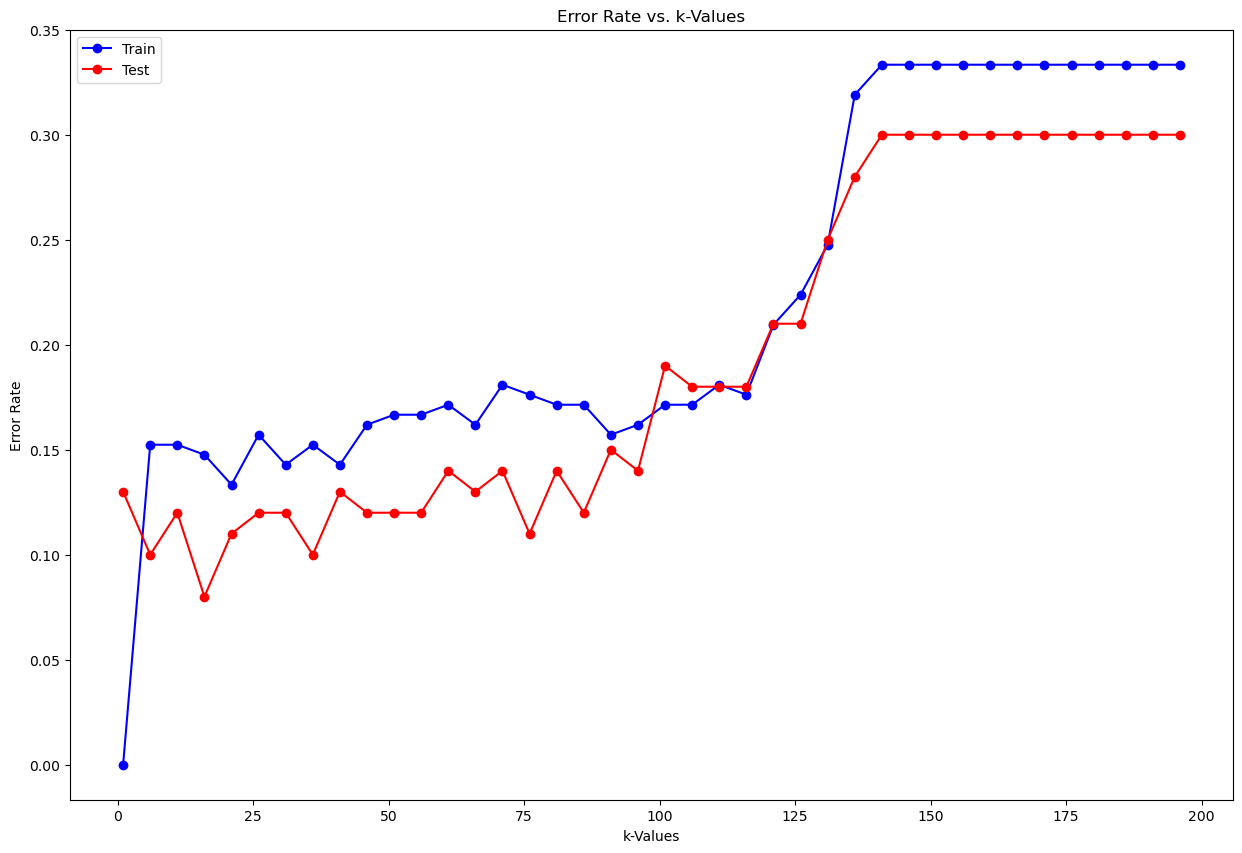

k* = 16
Best Chebyshev Distance Test Error: 0.08
Chebyshev Distance Train Error: 0.15


In [15]:
best_k_chebyshev, best_error_chebyshev, train_error_chebyshev = best_k('chebyshev', np.inf, X_train, y_train, X_test, y_test)
print('k* =', best_k_chebyshev)
print(f'Best Chebyshev Distance Test Error: {best_error_chebyshev:.2f}')
print(f'Chebyshev Distance Train Error: {train_error_chebyshev:.2f}')

# *Mahalanobis Distance*

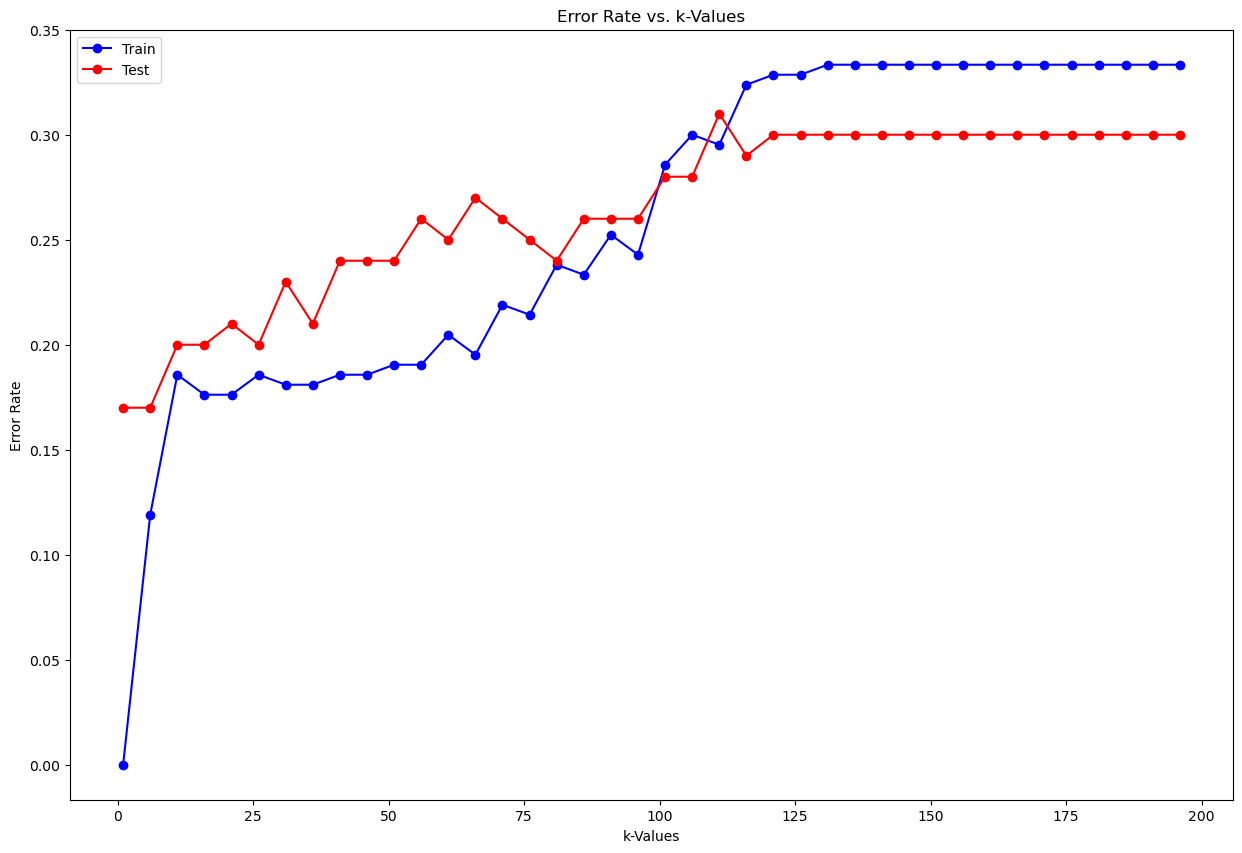

k* = 1
Best Mahalanobis Distance Test Error: 0.17
Mahalanobis Distance Train Error: 0.00


In [16]:
k_range = list(range(1, 197, 5))
test_errors = []
train_errors = []

cov_matrix = np.cov(X_train, rowvar=False)
inv_cov_matrix = inv(cov_matrix)

for k in k_range:
    knn_mahalanobis = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': inv_cov_matrix})
    knn_mahalanobis.fit(X_train, y_train)
    y_test_pred = knn_mahalanobis.predict(X_test)
    y_train_pred = knn_mahalanobis.predict(X_train)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    train_error  = 1 - accuracy_score(y_train, y_train_pred)
    test_errors.append(test_error)
    train_errors.append(train_error)

# Plot the data
plt.figure(figsize=(15, 10))
plt.plot(k_range, train_errors, marker='o', linestyle='-', color='b', label='Train')
plt.plot(k_range, test_errors, marker='o', linestyle='-', color='r', label='Test')

# Add titles and labels
plt.title('Error Rate vs. k-Values')
plt.xlabel('k-Values')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

best_error_mahalanobis = min(test_errors)
best_index = test_errors.index(min(test_errors))
best_k_mahalanobis = k_range[best_index]
train_error_mahalanobis = train_errors[best_index]

print('k* =', best_k_mahalanobis)
print(f'Best Mahalanobis Distance Test Error: {best_error_mahalanobis:.2f}')
print(f'Mahalanobis Distance Train Error: {train_error_mahalanobis:.2f}')

In [17]:
info = {'Model': ['KNN w/ Manhattan Distance', 'KNN w/ log(p)', 'KNN w/ Chebyshev Distance', 'KNN w/ Mahalanobis Distance'], 
        'Best k-Value': [best_k_manhattan, best_k_manhattan, best_k_chebyshev, best_k_mahalanobis], 
        'Test Error': [best_error_manhattan, best_error_minkowski, best_error_chebyshev, best_error_mahalanobis],
        'Training Error': [train_error_manhattan, train_error_minkowski, train_error_chebyshev, train_error_mahalanobis]}

performance_table = pd.DataFrame(info)
performance_table

,Model,Best k-Value,Test Error,Training Error
0,KNN w/ Manhattan Distance,6,0.11,0.138095
1,KNN w/ log(p),6,0.06,0.152381
2,KNN w/ Chebyshev Distance,16,0.08,0.147619
3,KNN w/ Mahalanobis Distance,1,0.17,0.000000


# Weighted Decision

In [18]:
def best_k_weighted_decision(metric, p_value, X_train, y_train, X_test, y_test):
    
    k_range = list(range(1, 197, 5))
    test_errors = []
    train_errors = []
    
    for k in k_range:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=p_value, weights='distance')
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        test_error = 1 - accuracy_score(y_test, y_test_pred)
        train_error  = 1 - accuracy_score(y_train, y_train_pred)
        test_errors.append(test_error)
        train_errors.append(train_error)
    
    # Plot the data
    plt.figure(figsize=(15, 10))
    plt.plot(k_range, train_errors, marker='o', linestyle='-', color='b', label='Train')
    plt.plot(k_range, test_errors, marker='o', linestyle='-', color='r', label='Test')
    
    # Add titles and labels
    plt.title('Error Rate vs. k-Values')
    plt.xlabel('k-Values')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.show()

    best_test_error = min(test_errors)
    best_index = test_errors.index(min(test_errors))
    best_k = k_range[best_index]
    train_error = train_errors[best_index]

    return best_k, best_test_error, train_error

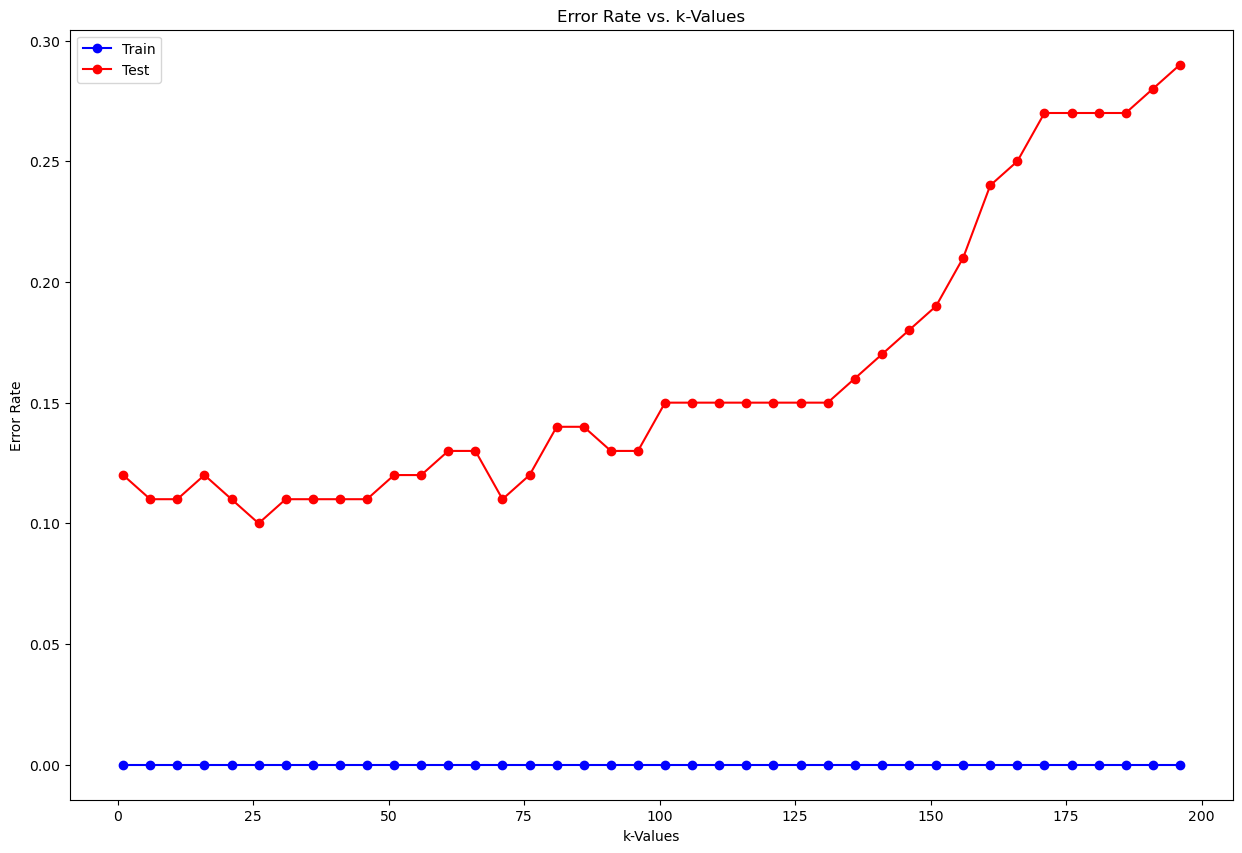

In [19]:
best_k_manhattan_weighted, best_error_manhattan_weighted, train_error_manhattan_weighted = best_k_weighted_decision('minkowski', 1, X_train, y_train, X_test, y_test)

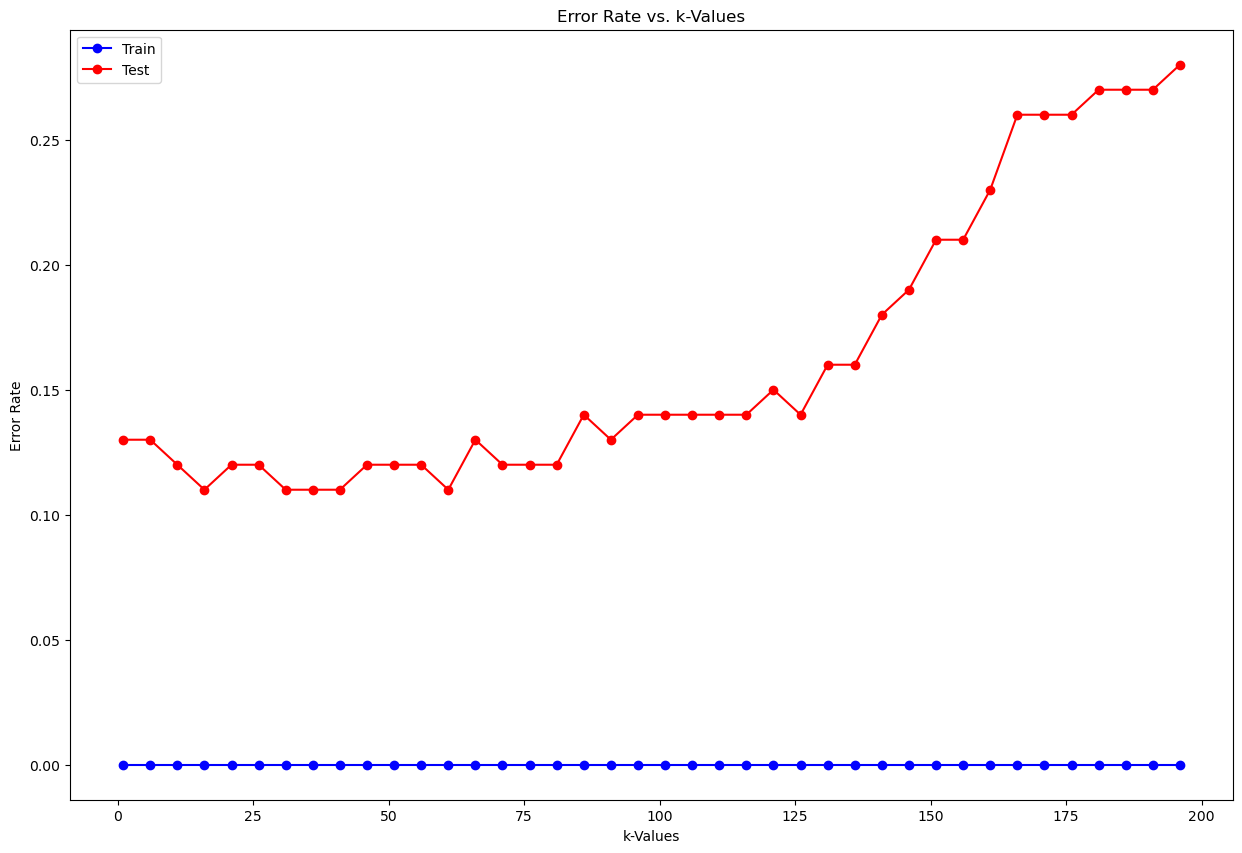

In [20]:
best_k_chebyshev_weighted, best_error_chebyshev_weighted, train_error_chebyshev_weighted = best_k_weighted_decision('chebyshev', np.inf, X_train, y_train, X_test, y_test)

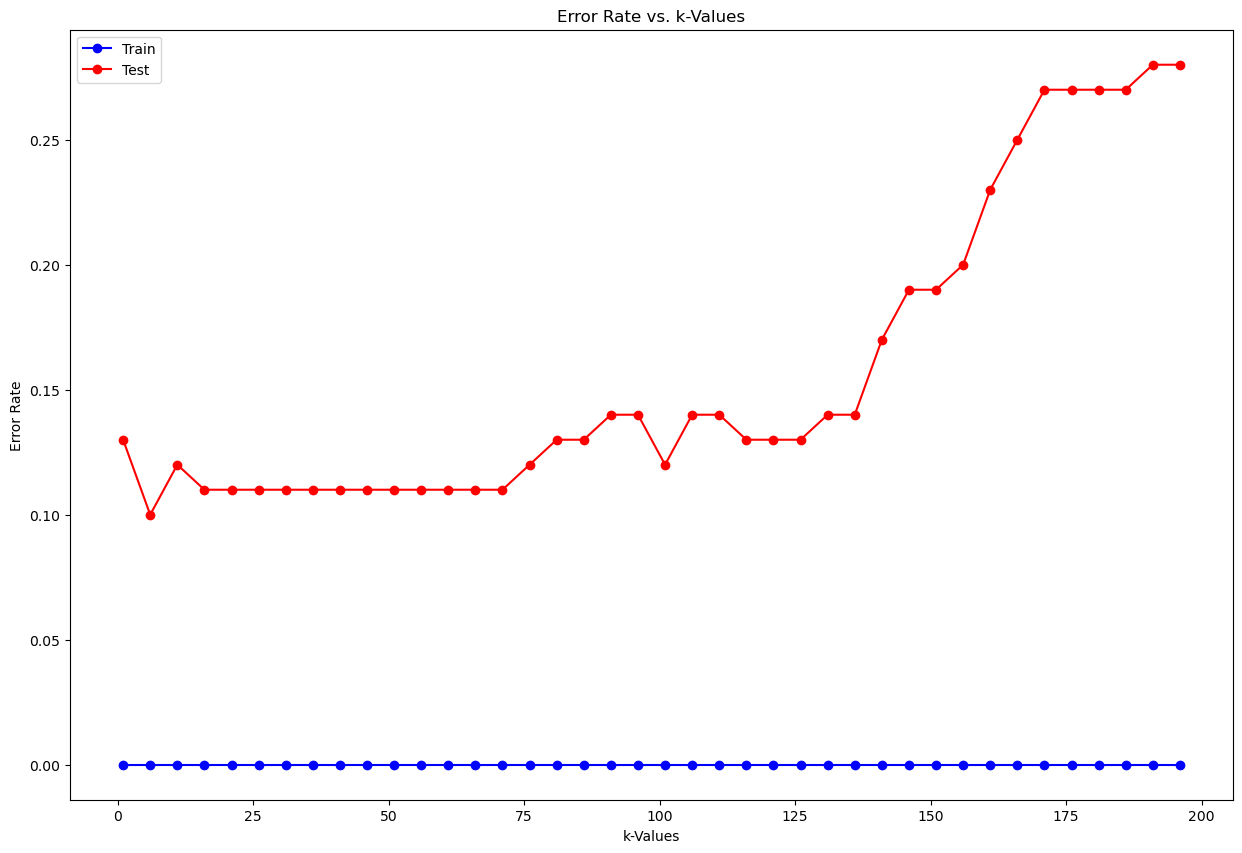

In [21]:
best_k_euclidean_weighted, best_error_euclidean_weighted, train_error_euclidean_weighted = best_k_weighted_decision('euclidean', None, X_train, y_train, X_test, y_test)

In [22]:
weighted_info = {'Model': ['Weighted KNN w/ Euclidean Distance', 'Weighted KNN w/ Manhattan Distance', 'Weighted KNN w/ Chebyshev Distance'], 
        'Best k-Value': [best_k_euclidean_weighted, best_k_manhattan_weighted, best_k_chebyshev_weighted], 
        'Test Error': [best_error_euclidean_weighted, best_error_manhattan_weighted, best_error_chebyshev_weighted], 
        'Training Error': [train_error_euclidean_weighted, train_error_manhattan_weighted, train_error_chebyshev_weighted]}

weighted_performance_table = pd.DataFrame(weighted_info)
weighted_performance_table

,Model,Best k-Value,Test Error,Training Error
0,Weighted KNN w/ Euclidean Distance,6,0.10,0.0
1,Weighted KNN w/ Manhattan Distance,26,0.10,0.0
2,Weighted KNN w/ Chebyshev Distance,16,0.11,0.0
